# Model with augmentation

In [15]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from math import floor
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [16]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Data Loading and split

In [17]:
X = np.load('/kaggle/input/homework2/x_train.npy')
y = np.load('/kaggle/input/homework2/y_train.npy')
label_classes = ['Wish', 'Another', 'Comfortably', 'Money', 'Breathe', 'Time', 'Brain', 'Echoes', 'Wearing','Sorrow','Hey','Shine']
# one hot encoding
labels = tfk.utils.to_categorical(y, num_classes=12)
X_train, X_valid, y_train, y_valid = train_test_split(X, labels, test_size=0.1, shuffle=True, stratify=labels)
print('\n\nTraining Set:')
print('Data shape: {}'.format(X_train.shape))
print('Labels shape: {}'.format(y_train.shape))
print('\nValidation Set:')
print('Data shape: {}'.format(X_valid.shape))
print('Labels shape: {}'.format(y_valid.shape))



Training Set:
Data shape: (2186, 36, 6)
Labels shape: (2186, 12)

Validation Set:
Data shape: (243, 36, 6)
Labels shape: (243, 12)


## Augmentation Functions

In [18]:
# removed to avoid license mistakes

## Building and training the model

In [19]:
input_shape = (36,6)

# LSTM model
def build_LSTM_classifier(input_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    lstm = tfkl.LSTM(128, return_sequences=True, name="feature_extractor_1")(input_layer)
    lstm = tfkl.LSTM(128, name="feature_extractor_2")(lstm)
    classifier = tfkl.Dense(units=128, name="classifier")(lstm)
    leaky = tfkl.LeakyReLU()(classifier)
    output_layer = tfkl.Dense(units=12, activation='softmax', name="output_layer")(leaky)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(5e-4), metrics='accuracy')
    return model

#build the model
model = build_LSTM_classifier(input_shape)

class_weight = {
    0: 1,
    1: 1,
    2: 1,
    3: 1.2,
    4: 1.5,
    5: 1.2,
    6: 1,
    7: 1.5,
    8: 0.5,
    9: 0.2,
    10: 1,
    11: 1.5,
}

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_valid, y_valid),
    class_weight = class_weight,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)]
).history

Epoch 1/200
137/137 [==============================] - 4s 12ms/step - loss: 1.3074 - accuracy: 0.3466 - val_loss: 1.4695 - val_accuracy: 0.4403
Epoch 2/200
137/137 [==============================] - 1s 7ms/step - loss: 0.8682 - accuracy: 0.5089 - val_loss: 1.2138 - val_accuracy: 0.5679
Epoch 3/200
137/137 [==============================] - 1s 7ms/step - loss: 0.6973 - accuracy: 0.5889 - val_loss: 1.2106 - val_accuracy: 0.5720
Epoch 4/200
137/137 [==============================] - 1s 7ms/step - loss: 0.5725 - accuracy: 0.6408 - val_loss: 1.2096 - val_accuracy: 0.5432
Epoch 5/200
137/137 [==============================] - 1s 7ms/step - loss: 0.4507 - accuracy: 0.6924 - val_loss: 1.2574 - val_accuracy: 0.5802
Epoch 6/200
137/137 [==============================] - 1s 7ms/step - loss: 0.3622 - accuracy: 0.7358 - val_loss: 1.3308 - val_accuracy: 0.6132
Epoch 7/200
137/137 [==============================] - 1s 7ms/step - loss: 0.2766 - accuracy: 0.7815 - val_loss: 1.3517 - val_accuracy: 0.592

## Plot and analysis

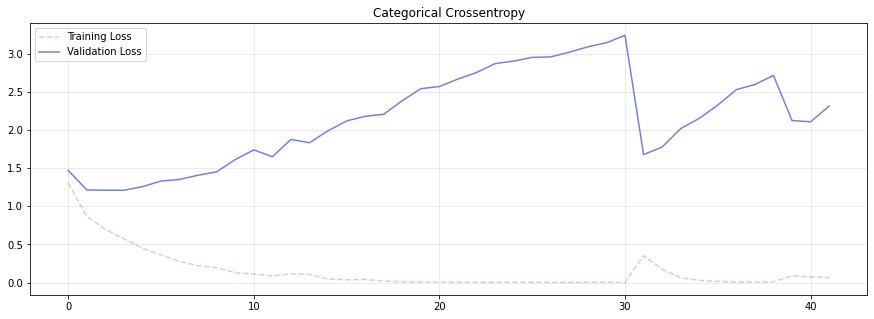

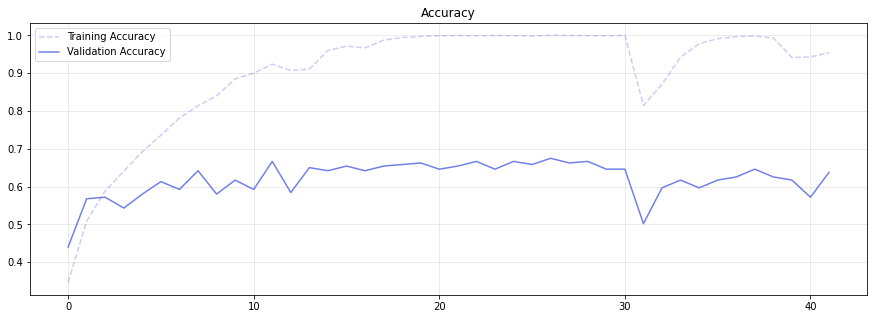

8/8 [==============================] - 0s 4ms/step - loss: 2.9587 - accuracy: 0.6749
{'loss': 2.9586660861968994, 'accuracy': 0.6748971343040466}
Accuracy:  0.6749
Precision: 0.6057
Recall:    0.5385
F1:        0.5544
Confusion matrix:
[[ 1  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  1  0  0]
 [ 0  1 24  0  0  0  0  0  0  0  1  0]
 [ 0  1  0 14  1  2  1  1  0  3  0  1]
 [ 0  0  0  1  2  0  0  0  0  3  0  0]
 [ 0  0  0  4  0  5  0  2  0  2  0  1]
 [ 1  2  1  1  0  0 28  0  0  1  0  0]
 [ 0  0  0  0  0  1  0  1  0  1  0  0]
 [ 0  2  0  0  0  0  1  0 11  2  0  0]
 [ 2  1  2 16  3  7  1  2  0 65  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  2  0  0  0  0  1  0  0  1]]


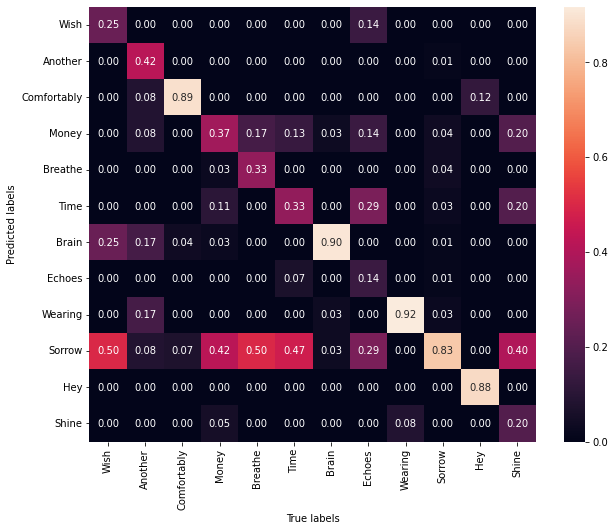

In [20]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = 'Training Accuracy', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.show()

model_test_metrics = model.evaluate(
    x=X_valid,
    y=y_valid,
    return_dict=True)
print(model_test_metrics)

# Predict the test set with the CNN
predictions = model.predict(X_valid)
true_labels = np.argmax(y_valid, axis=-1)
predicted_labels = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Compute the classification metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
print('Accuracy: ', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:   ', recall.round(4))
print('F1:       ', f1.round(4))
print('Confusion matrix:')
print(np.transpose(cm))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_rel.T, xticklabels=label_classes, yticklabels=label_classes, annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [21]:
model.save("AugModel")
!zip -r output.zip ./AugModel

updating: AugModel/ (stored 0%)
updating: AugModel/saved_model.pb (deflated 89%)
updating: AugModel/variables/ (stored 0%)
updating: AugModel/variables/variables.data-00000-of-00001 (deflated 7%)
updating: AugModel/variables/variables.index (deflated 66%)
updating: AugModel/keras_metadata.pb (deflated 90%)
updating: AugModel/assets/ (stored 0%)
